# One Pixel Attack Tutorial
## Part 2

### Dan Kondratyuk
### March 18, 2018

![](images/pred3.png "This attack works on even larger images")

## Imports

Ensure that you have `numpy`, `pandas`, `scipy`, `matplotlib`, `tensorflow-gpu`, and `keras` installed.

In [1]:
# Python Libraries
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.imagenet_utils import decode_predictions, preprocess_input

# Helper functions
from differential_evolution import differential_evolution
import helper
from attack import PixelAttacker

matplotlib.style.use('ggplot')

/home/hyper/Documents/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load Dataset

In [2]:
url = 'http://farm4.static.flickr.com/3154/2585091536_78f528fdee.jpg'
filename = 'data/balloon.jpg'
helper.download_from_url(url, filename)

122kB [00:00, 193kB/s]


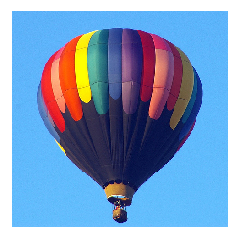

In [3]:
original = load_img(filename, target_size=(224, 224)) # Load an image in PIL format
image = img_to_array(original) # Convert the PIL image to a numpy array
image_batch = np.expand_dims(image, axis=0) # Convert the image into batch format
helper.plot_image(image)

## Load Model

In [4]:
model = keras.applications.MobileNet()

In [5]:
processed_image = preprocess_input(image_batch.copy()) # Prepare the image for the model
predictions = model.predict(processed_image) # Get the predicted probabilities for each class
label = decode_predictions(predictions) # Convert the probabilities to class labels
label

[[('n02782093', 'balloon', 0.99706227),
  ('n03888257', 'parachute', 0.0022517033),
  ('n03720891', 'maraca', 0.00042275584),
  ('n03443371', 'goblet', 5.5172597e-05),
  ('n04409515', 'tennis_ball', 4.3753058e-05)]]

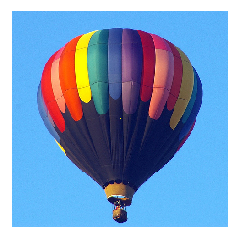

In [6]:
pixel = np.array([112, 112, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = helper.perturb_image(pixel, image)[0]
helper.plot_image(image_perturbed)

In [7]:
predictions = model.predict(np.expand_dims(image_perturbed, axis=0))
label = decode_predictions(predictions)
label

[[('n03888257', 'parachute', 0.8554896),
  ('n01910747', 'jellyfish', 0.06641229),
  ('n02782093', 'balloon', 0.0593146),
  ('n04209239', 'shower_curtain', 0.0044504665),
  ('n02606052', 'rock_beauty', 0.0034509634)]]

In [ ]:
models = [model]

In [ ]:
attacker = PixelAttacker(models, test, class_names)

In [ ]:
attacker.attack(image, model, dimensions=(224, 224), plot=True)

In [8]:
target=None
pixel_count=1
maxiter=75
popsize=1000
verbose=True
dimensions=(224, 224)

# Change the target class based on whether this is a targeted attack or not
target_class = 417

# Define bounds for a flat vector of x,y,r,g,b values
# For more pixels, repeat this layout
dim_x, dim_y = dimensions
bounds = [(0,dim_x), (0,dim_y), (0,256), (0,256), (0,256)] * pixel_count

# Population multiplier, in terms of the size of the perturbation vector x
popmul = max(1, popsize // len(bounds))

# Format the predict/callback functions for the differential evolution algorithm
predict_fn = lambda xs: attacker.predict_classes(
    xs, image, target_class, model, target is None)
callback_fn = lambda x, convergence: attacker.attack_success(
    x, image, target_class, model, False, verbose)

# Call Scipy's Implementation of Differential Evolution
attack_result = differential_evolution(
    predict_fn, bounds, maxiter=maxiter, popsize=popmul,
    atol=-1, callback=callback_fn, polish=False)

# Calculate some useful statistics to return from this function
attack_image = helper.perturb_image(attack_result.x, image)[0]
helper.plot_image(attack_image)

NameError: name 'attacker' is not defined

In [18]:
predictions = model.predict(np.expand_dims(attack_image, axis=0))
label = decode_predictions(predictions)
label

[[('n03888257', 'parachute', 0.6999467),
  ('n01910747', 'jellyfish', 0.18020728),
  ('n02782093', 'balloon', 0.082448356),
  ('n04209239', 'shower_curtain', 0.007684508),
  ('n02606052', 'rock_beauty', 0.006214261)]]

In [ ]:
# Should output /device:GPU:0
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

### Attack Statistics

Print the final results! 

In [19]:
# Load the results
untargeted, targeted = helper.load_results()

In [20]:
columns = ['model', 'pixels', 'image', 'true', 'predicted', 'success', 'cdiff', 'prior_probs', 'predicted_probs', 'perturbation']
untargeted_results = pd.DataFrame(untargeted, columns=columns)
targeted_results = pd.DataFrame(targeted, columns=columns)

#### Untargeted

In [21]:
helper.attack_stats(untargeted_results, models, network_stats)

,model,accuracy,pixels,attack_success_rate
0,lecun_net,0.7488,1,0.63
1,lecun_net,0.7488,3,0.92
2,lecun_net,0.7488,5,0.93
3,pure_cnn,0.8877,1,0.13
4,pure_cnn,0.8877,3,0.58
5,pure_cnn,0.8877,5,0.63
6,net_in_net,0.9074,1,0.34
7,net_in_net,0.9074,3,0.73
8,net_in_net,0.9074,5,0.73
9,resnet,0.9231,1,0.34


#### Targeted

In [22]:
helper.attack_stats(targeted_results, models, network_stats)

,model,accuracy,pixels,attack_success_rate
0,lecun_net,0.7488,1,0.344444
1,lecun_net,0.7488,3,0.644444
2,lecun_net,0.7488,5,0.644444
3,pure_cnn,0.8877,1,0.066667
4,pure_cnn,0.8877,3,0.133333
5,pure_cnn,0.8877,5,0.188889
6,net_in_net,0.9074,1,0.100000
7,net_in_net,0.9074,3,0.244444
8,net_in_net,0.9074,5,0.311111
9,resnet,0.9231,1,0.144444


### Show some successful attacks

Plot 9 random successful attack images

Untargeted Attack


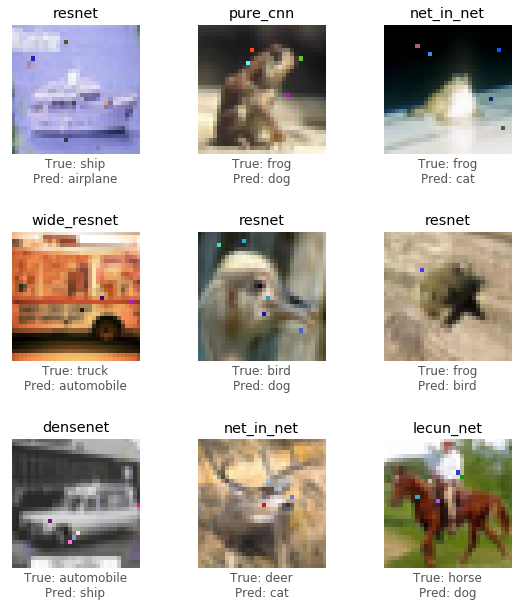

In [23]:
print('Untargeted Attack')
helper.visualize_attack(untargeted_results, class_names)

Targeted Attack


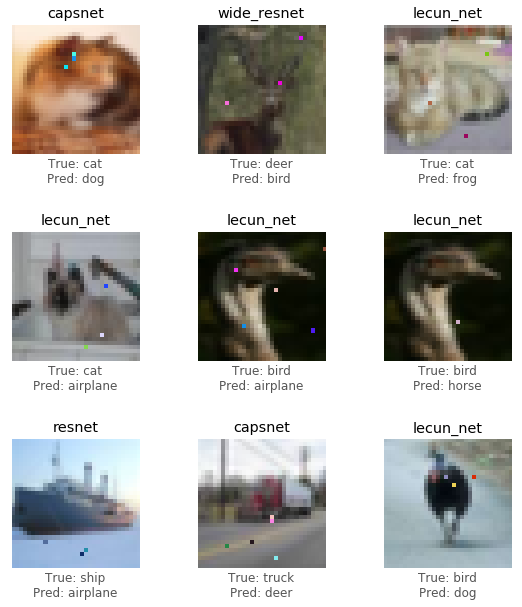

In [25]:
print('Targeted Attack')
helper.visualize_attack(targeted_results, class_names)